# Categorical Values

A categorical variable, as the name suggests, is used to represent categories or labels. For instance, a categorical variable could represent major cities in the world, the four seasons in a year, or the industry (oil, travel, technology) of a company. The number of category values is always finite in a real-world dataset. The values may be represented numerically. However, unlike other numeric variables, the values of a categorical variable cannot be ordered with respect to one another. (Oil is neither greater than nor less than travel as an industry type.) They are called nonordinal.

A simple question can serve as litmus test for whether something should be a categorical variable: “Does it matter how different two values are, or only that they are different?” A stock price of 500 € is five times higher than a price of 100 €. So, stock price should be represented by a continuous numeric variable. The industry of the company (oil, travel, tech, etc.), on the other hand, should probably be categorical.

Large categorical variables are particularly common in transactional records. For instance, many web services track users using an ID, which is a categorical variable with hundreds to hundreds of millions of values, depending on the number of unique users of the service. 

The IP address of an internet transaction is another example of a large categorical variable. They are categorical variables because, even though user IDs and IP addresses are numeric, their magnitude is usually not relevant to the task at hand. For instance, the IP address might be relevant when doing fraud detection on individual transactions—some IP addresses or subnets may generate more fraudulent transactions than others. But a subnet of 164.203.x.x is not inherently more fraudulent than 164.202.x.x; the numeric value of the subnet does not matter.

The vocabulary of a document corpus can be interpreted as a large categorical variable, with the categories being unique words. It can be computationally expensive to represent so many distinct categories. If a category (e.g., word) appears multiple times in a data point (document), then we can represent it as a count, and represent all of the categories through their count statistics. 

This is called bin counting. We start this discussion with common representations of categorical variables, and eventually meander our way to a discussion of bin counting for large categorical variables, which are very common in modern datasets.

# Encoding Categorical Variables

The categories of a categorical variable are usually not numeric.1 For example, eye color can be “black,” “blue,” “brown,” etc. Thus, an encoding method is needed to turn these nonnumeric categories into numbers. It is tempting to simply assign an integer, say from 1 to k, to each of k possible categories—but the resulting values would be orderable against each other, which should not be permissible for categories. So, let’s look at some alternatives.
One-Hot Encoding

A better method is to use a group of bits. Each bit represents a possible category. If the variable cannot belong to multiple categories at once, then only one bit in the group can be “on.” This is called one-hot encoding, and it is implemented in scikit-learn as sklearn.preprocessing.OneHotEncoder. Each of the bits is a feature. Thus, a categorical variable with k possible categories is encoded as a feature vector of length k. Table 5-1 shows an example.

![texto alternativo](https://drive.google.com/uc?id=1qL2klfmXws6LXfhgLD2WPLT544cr9BlT)

One-hot encoding is very simple to understand, but it uses one more bit than is strictly necessary. If we see that k–1 of the bits are 0, then the last bit must be 1 because the variable must take on one of the k values. Mathematically, one can write this constraint as “the sum of all bits must be equal to 1”:
e 1 + e 2 + . . . + e k = 1

Thus, we have a linear dependency on our hands. Linear dependent features, as we discovered in Chapter 4, are slightly annoying because they mean that the trained linear models will not be unique. Different linear combinations of the features can make the same predictions, so we would need to jump through extra hoops to understand the effect of a feature on the prediction.


## Dummy Coding

The problem with one-hot encoding is that it allows for k degrees of freedom, while the variable itself needs only k–1. Dummy coding2 removes the extra degree of freedom by using only k–1 features in the representation (see Table 5-2). One feature is thrown under the bus and represented by the vector of all zeros. This is known as the reference category. Dummy coding and one-hot encoding are both implemented in Pandas as pandas.get_dummies.
Table 5-2. Dummy coding of a category of three cities 

The outcome of modeling with dummy coding is more interpretable than with one-hot encoding. This is easy to see in a simple linear regression problem. Suppose we have some data about apartment rental prices in three cities: San Francisco, New York, and Seattle (see Table 5-3).
Table 5-3. Toy dataset of apartment prices in three cities

In [1]:
import pandas as pd
from sklearn import linear_model

In [3]:
df = pd.DataFrame({'City': ['SF', 'SF', 'SF', 'NYC', 'NYC', 'NYC', 'Seattle', 'Seattle', 'Seattle'],'Rent': [3999, 4000, 4001, 3499, 3500, 3501, 2499, 2500, 2501]})
df

,City,Rent
0,SF,3999
1,SF,4000
2,SF,4001
3,NYC,3499
4,NYC,3500
5,NYC,3501
6,Seattle,2499
7,Seattle,2500
8,Seattle,2501


In [4]:
one_hot_df = pd.get_dummies(df, prefix=['city'])

one_hot_df

,Rent,city_NYC,city_SF,city_Seattle
0,3999,0,1,0
1,4000,0,1,0
2,4001,0,1,0
3,3499,1,0,0
4,3500,1,0,0
5,3501,1,0,0
6,2499,0,0,1
7,2500,0,0,1
8,2501,0,0,1


In [5]:
lin_reg = linear_model.LinearRegression()

In [6]:
lin_reg.fit(one_hot_df[['city_NYC', 'city_SF', 'city_Seattle']], one_hot_df['Rent'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [7]:
lin_reg.coef_

array([ 166.66666667,  666.66666667, -833.33333333])

In [8]:
lin_reg.intercept_

3333.3333333333335

In [9]:
# One-hot encoding weights + intercept
w1 = lin_reg.coef_
b1 = lin_reg.intercept_

In [10]:
df['Rent'].mean()

3333.3333333333335

In [11]:
dummy_df = pd.get_dummies(df, prefix=['city'], drop_first=True)
dummy_df

,Rent,city_SF,city_Seattle
0,3999,1,0
1,4000,1,0
2,4001,1,0
3,3499,0,0
4,3500,0,0
5,3501,0,0
6,2499,0,1
7,2500,0,1
8,2501,0,1


In [12]:
lin_reg.fit(dummy_df[['city_SF', 'city_Seattle']], dummy_df['Rent'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [13]:
lin_reg.coef_

array([  500., -1000.])

In [14]:
lin_reg.intercept_

3500.0

In [15]:
# Dummy coding weights + intercept
w2 = lin_reg.coef_
b2 = lin_reg.intercept_

In [16]:
effect_df = dummy_df.copy()

In [17]:
effect_df.loc[3:5, ['city_SF', 'city_Seattle']] = -1.0
effect_df

,Rent,city_SF,city_Seattle
0,3999,1.0,0.0
1,4000,1.0,0.0
2,4001,1.0,0.0
3,3499,-1.0,-1.0
4,3500,-1.0,-1.0
5,3501,-1.0,-1.0
6,2499,0.0,1.0
7,2500,0.0,1.0
8,2501,0.0,1.0


In [18]:
lin_reg.fit(effect_df[['city_SF', 'city_Seattle']], effect_df['Rent'])
lin_reg.coef_

array([ 666.66666667, -833.33333333])

In [19]:
lin_reg.intercept_

3333.3333333333335

In [20]:
# illustration of rental price in cities
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", font_scale=1.4, color_codes=True)

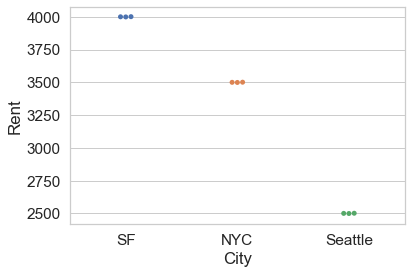

In [21]:
sns.swarmplot(x="City", y="Rent", data=df);

In [22]:
print('One-hot encoding weights: ' ,w1, ' and intercept: ', b1)
print('Dummy encoding weights: ' ,w2, ' and intercept: ', b2)

One-hot encoding weights:  [ 166.66666667  666.66666667 -833.33333333]  and intercept:  3333.3333333333335
Dummy encoding weights:  [  500. -1000.]  and intercept:  3500.0


In [23]:
# geometry of one-hot vs. dummy encoding

# Create a list of values in the best fit line for one-hot encoding
one_hot_y = [((w1[0] * one_hot_df.city_NYC[i]) + 
              (w1[1] * one_hot_df.city_SF[i]) +
              (w1[2] * one_hot_df.city_Seattle[i]) + b1) 
             for i in range(0,one_hot_df.shape[0])]

# Create a list of values in the best fit line for dummy coding
dummy_y = [((w2[0] * dummy_df.city_SF[i]) +
            (w2[1] * dummy_df.city_Seattle[i]) + b2)
           for i in range(0,dummy_df.shape[0])]

print(one_hot_y)
print(dummy_y)

[4000.0000000000005, 4000.0000000000005, 4000.0000000000005, 3500.0, 3500.0, 3500.0, 2500.0, 2500.0, 2500.0]
[3999.9999999999995, 3999.9999999999995, 3999.9999999999995, 3500.0, 3500.0, 3500.0, 2500.0, 2500.0, 2500.0]



Pros and Cons of Categorical Variable Encodings

One-hot, dummy, and effect coding are very similar to one another. They each have pros and cons. One-hot encoding is redundant, which allows for multiple valid models for the same problem. The nonuniqueness is sometimes problematic for interpretation, but the advantage is that each feature clearly corresponds to a category. Moreover, missing data can be encoded as the all-zeros vector, and the output should be the overall mean of the target variable.

Dummy coding and effect coding are not redundant. They give rise to unique and interpretable models. The downside of dummy coding is that it cannot easily handle missing data, since the all-zeros vector is already mapped to the reference category. It also encodes the effect of each category relative to the reference category, which may look strange.

Effect coding avoids this problem by using a different code for the reference category, but the vector of all –1’s is a dense vector, which is expensive for both storage and computation. For this reason, popular ML software packages such as Pandas and scikit-learn have opted for dummy coding or one-hot encoding instead of effect coding.

All three encoding techniques break down when the number of categories becomes very large. Different strategies are needed to handle extremely large categorical variables. 

## Dealing with Large Categorical Variables

Automated data collection on the internet can generate large categorical variables. This is common in applications such as targeted advertising and fraud detection.

In targeted advertising, the task is to match a user with a set of ads. Features include the user ID, the website domain for the ad, the search query, the current page, and all possible pairwise conjunctions of those features. (The query is a text string that can be chopped up and turned into the usual text features. However, queries are generally short and are often composed of phrases, so the best course of action in this case is usually to keep them intact, or pass them through a hash function to make storage and comparisons easier. We will discuss hashing in more detail later.) Each of these is a very large categorical variable. The challenge is to find a good feature representation that is memory efficient, yet produces accurate models that are fast to train.

Existing solutions can be categorized (haha) thus:

    Do nothing fancy with the encoding. Use a simple model that is cheap to train. Feed one-hot encoding into a linear model (logistic regression or linear support vector machine) on lots of machines.
    Compress the features. There are two choices:
        Feature hashing, popular with linear models
        Bin counting, popular with linear models as well as trees

Using the vanilla one-hot encoding is a valid option. For Microsoft’s search advertising engine, Graepel et al. (2010) report using such binary-valued features in a Bayesian probit regression model that can be trained online using simple updates. Meanwhile, other groups argue for the compression approach. Researchers from Yahoo! swear by feature hashing (Weinberger et al., 2009), though McMahan et al. (2013) experimented with feature hashing on Google’s advertising engine and did not find significant improvements. Yet other folks at Microsoft are taken with the idea of bin counting (Bilenko, 2015).

As we shall see, all of these ideas have pros and cons. We will first describe the solutions themselves, then discuss their trade-offs.

## Feature Hashing

A hash function is a deterministic function that maps a potentially unbounded integer to a finite integer range [1, m]. Since the input domain is potentially larger than the output range, multiple numbers may get mapped to the same output. This is called a collision. A uniform hash function ensures that roughly the same number of numbers are mapped into each of the m bins.

Visually, we can think of a hash function as a machine that intakes numbered balls (keys) and routes them to one of m bins. Balls with the same number will always get routed to the same bin (see Figure 5-1). This maintains the feature space while reducing the storage and processing time during machine learning training and evaluation cycles.

Hash functions can be constructed for any object that can be represented numerically (which is true for any data that can be stored on a computer): numbers, strings, complex structures, etc.

![texto alternativo](https://drive.google.com/uc?id=1cTY_mxkTAS33w9ck-Pn_8v67LspVGnTe)

Feature hashing can be used for models that involve the inner product of feature vectors and coefficients, such as linear models and kernel methods. It has been demonstrated to be successful in the task of spam filtering (Weinberger et al., 2009). In the case of targeted advertising, McMahan et al. (2013) report not being able to get the prediction errors down to an acceptable level unless m is on the order of billions, which does not constitute enough saving in space.

One downside to feature hashing is that the hashed features, being aggregates of original features, are no longer interpretable.

In Example 5-5, we use the Yelp reviews dataset to demonstrate storage and interpretability trade-offs using scikit-learn’s FeatureHasher.

In [24]:
import pandas as pd
import json

In [25]:
# Load the first 10000 reviews
f = open('data/yelp/v6/yelp_dataset_challenge_academic_dataset/yelp_academic_dataset_review.json')
js = []
for i in range(10000):
    js.append(json.loads(f.readline()))
f.close()
review_df = pd.DataFrame(js)
review_df.shape

FileNotFoundError: [Errno 2] No such file or directory: 'data/yelp/v6/yelp_dataset_challenge_academic_dataset/yelp_academic_dataset_review.json'

In [26]:
# we will define m as equal to the unique number of business_id
m = len(review_df.business_id.unique())
print(m)

NameError: name 'review_df' is not defined

In [27]:
from sklearn.feature_extraction import FeatureHasher

In [28]:
h = FeatureHasher(n_features=m, input_type='string')
f = h.transform(review_df['business_id'])

NameError: name 'm' is not defined

In [29]:
# We can see how this will make a difference in the future by looking at the size of each
from sys import getsizeof

print('Our pandas Series, in bytes: ', getsizeof(review_df['business_id']))
print('Our hashed numpy array, in bytes: ', getsizeof(f))

NameError: name 'review_df' is not defined

In [30]:
review_df['business_id'].unique().tolist()[0:5]

NameError: name 'review_df' is not defined

In [31]:
f.toarray()

NameError: name 'f' is not defined

## Bin Counting

Bin counting is one of the perennial rediscoveries in machine learning. It has been reinvented and used in a variety of applications, from ad click-through rate prediction to hardware branch prediction (Yeh and Patt, 1991; Lee et al., 1998; Chen et al., 2009; Li et al., 2010). Yet because it is a feature engineering technique and not a modeling or optimization method, there is no research paper on the topic. The most detailed description of the technique can be found in Misha Bilenko’s (2015) blog post “Big Learning Made Easy—with Counts!” and the associated slides.

The idea of bin counting is deviously simple: rather than using the value of the categorical variable as the feature, instead use the conditional probability of the target under that value. In other words, instead of encoding the identity of the categorical value, we compute the association statistics between that value and the target that we wish to predict. For those familiar with naive Bayes classifiers, this statistic should ring a bell, because it is the conditional probability of the class under the assumption that all features are independent. It is best illustrated with an example (see Table 5-6).

![texto alternativo](https://drive.google.com/uc?id=1Zz3RhCWdF-Zf_q0ro_Lrjqj_LZK8auJ_)

Bin counting assumes that historical data is available for computing the statistics. Table 5-6 contains aggregated historical counts for each possible value of the categorical variables. Based on the number of times the user “Alice” has clicked on any ad and the number of times she has not clicked, we can calculate the probability of her clicking on any ad. Similarly, we can compute the probability of a click for any query–ad domain combination. At training time, every time we see “Alice,” we can use her probability of click as the input feature to the model. The same goes for QueryHash–AdDomain pairs like “0x437a45e1, qux.net.”

Suppose there were 10,000 users. One-hot encoding would generate a sparse vector of length 10,000, with a single 1 in the column that corresponds to the value of the current data point. Bin counting would encode all 10,000 binary columns as a single feature with a real value between 0 and 1.

We can include other features in addition to the historical click-through probability: the raw counts themselves (number of clicks and nonclicks), the log-odds ratio, or any other derivatives of probability. Our example here is for predicting ad click-through rates, but the technique readily applies to general binary classification. It can also be readily extended to multiclass classification using the usual techniques to extend binary classifiers to multiclass; i.e., via one-against-many odds ratios or other multiclass label encodings.

In short, bin counting converts a categorical variable into statistics about the value. It turns a large, sparse, binary representation of the categorical variable, such as that produced by one-hot encoding, into a very small, dense, real-valued numeric representation (Figure 5-2).

n terms of implementation, bin counting requires storing a map between each category and its associated counts. (The rest of the statistics can be derived on the fly from the raw counts.) Hence it requires O(k) space, where k is the number of unique values of the categorical variable.

To illustrate bin counting in practice, we’ll use data from a Kaggle competition hosted by Avazu. Here are some relevant statistics about the dataset:

- There are 24 variables, including click, a binary click/no click counter, and device_id, which tracks which device an ad was displayed on.
- The full dataset contains 40,428,967 observations, with 2,686,408 unique devices.

The aim of the Avazu competition was to predict click-through rate using ad data, but we will use the dataset to demonstrate how bin counting can greatly reduce the feature space for large amounts of streaming data.

## Bin counting Example

In [32]:
import pandas as pd

- [Click-through ad data from Kaggle competition](https://www.kaggle.com/c/avazu-ctr-prediction/data)
- train_subset is first 10K rows of 6+GB set

In [33]:
df = pd.read_csv('data/train_subset.csv')

FileNotFoundError: [Errno 2] File b'data/train_subset.csv' does not exist: b'data/train_subset.csv'

In [34]:
df.head(3)

,City,Rent
0,SF,3999
1,SF,4000
2,SF,4001


In [35]:
# how many features should we have after?
len(df['device_id'].unique())

KeyError: 'device_id'

Features are $\theta$ = [$N^+$, $N^-$, $log(N^+)-log(N^-)$, isRest]

$N^+$ = $p(+)$ = $n^+/(n^+ + n^-)$

$N^-$ = $p(-)$ = $n^-/(n^+ + n^-)$

$log(N^+)-log(N^-)$ = $\frac{p(+)}{p(-)}$

isRest = back-off bin (not shown here)

In [36]:
def click_counting(x, bin_column):
    clicks = pd.Series(x[x['click'] > 0][bin_column].value_counts(), name='clicks')
    no_clicks = pd.Series(x[x['click'] < 1][bin_column].value_counts(), name='no_clicks')
    
    counts = pd.DataFrame([clicks,no_clicks]).T.fillna('0')
    counts['total'] = counts['clicks'].astype('int64') + counts['no_clicks'].astype('int64')
    
    return counts

def bin_counting(counts):
    counts['N+'] = counts['clicks'].astype('int64').divide(counts['total'].astype('int64'))
    counts['N-'] = counts['no_clicks'].astype('int64').divide(counts['total'].astype('int64'))
    counts['log_N+'] = counts['N+'].divide(counts['N-'])

#    If we wanted to only return bin-counting properties, we would filter here
    bin_counts = counts.filter(items= ['N+', 'N-', 'log_N+'])
    return counts, bin_counts

In [37]:
# bin counts example: device_id
bin_column = 'device_id'
device_clicks = click_counting(df.filter(items= [bin_column, 'click']), bin_column)
device_all, device_bin_counts = bin_counting(device_clicks)

KeyError: 'click'

In [38]:
# check to make sure we have all the devices
len(device_bin_counts)

NameError: name 'device_bin_counts' is not defined

In [39]:
device_all.sort_values(by = 'total', ascending=False).head(4)

NameError: name 'device_all' is not defined

In [40]:
# We can see how this can change model evaluation time by comparing raw vs. bin-counting size
from sys import getsizeof

print('Our pandas Series, in bytes: ', getsizeof(df.filter(items= ['device_id', 'click'])))
print('Our bin-counting feature, in bytes: ', getsizeof(device_bin_counts))

Our pandas Series, in bytes:  152


NameError: name 'device_bin_counts' is not defined